# 1. ***Load, Analyse and Preprocess the Data***

In [ ]:
# !unzip lfwa.zip #load images from zip

In [382]:
import csv
# load the train and test samples
with open(f'train.txt', 'r') as f:
    train = list(csv.reader(f, delimiter='\t'))[1:]
with open(f'test.txt', 'r') as f:
    test= list(csv.reader(f, delimiter='\t'))[1:]

In [383]:
# check each size for split to train and test
len(train),len(test)

(2200, 1000)

## ***1.1 Visualize Images- Croped and with Augumantation***

In [384]:
import torch
from PIL import Image
import numpy as np
from torch.utils.data import Dataset
from torchvision import transforms

class CustomCropTransform:
    def __init__(self, border_pixels):
        self.border_pixels = border_pixels

    def __call__(self, image):
        width, height = image.size
        left, top, right, bottom = self.border_pixels, self.border_pixels, width - self.border_pixels, height - self.border_pixels
        cropped_image = image.crop((left, top, right, bottom))
        return cropped_image

class ImageLoader(Dataset):
    def __init__(self, text_data, train=True):
        self.text_data = text_data
        if train:
            self.transform = transforms.Compose([
                CustomCropTransform(25),  # Apply custom crop transform
                transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
                transforms.RandomRotation(degrees=10),  # Randomly rotate the image by up to 10 degrees
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust brightness, contrast, saturation, and hue
                transforms.Resize((105, 105)),  # Resize to 105x105 pixels
                transforms.ToTensor(),  # Convert to a PyTorch tensor
                transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values
            ])
        else:
            self.transform = transforms.Compose([
                CustomCropTransform(25),  # Apply custom crop transform
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust brightness, contrast, saturation, and hue
                transforms.Resize((105, 105)),  # Resize to 105x105 pixels
                transforms.ToTensor(),  # Convert to a PyTorch tensor
                transforms.Normalize((0.5,), (0.5,))])  # Normalize pixel values

    def __len__(self):
        return len(self.text_data) 
    

    def loadAndPreprocessImage(self, name, number):
        number = '{:04d}'.format(int(number))
        image = Image.open(f"./lfw2/lfw2/{name}/{name}_{number}.jpg")

        return self.transform(image)
        

    def __getitem__(self, idx):
        data = self.text_data[idx]

        if len(data) == 3:
            person1, image_num_1, image_num_2 = data # same person
            person2 = person1
            label = 1.0
        else:
            person1, image_num_1, person2, image_num_2 = data #not same person
            label = 0.0

        image1 = self.loadAndPreprocessImage(person1, image_num_1)
        image2 = self.loadAndPreprocessImage(person2, image_num_2)

        return image1, image2, torch.tensor(label)

Cropped Images


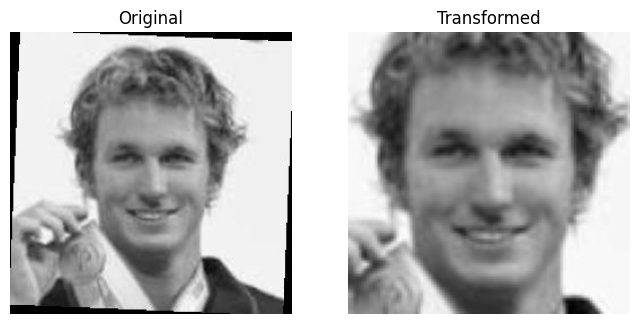

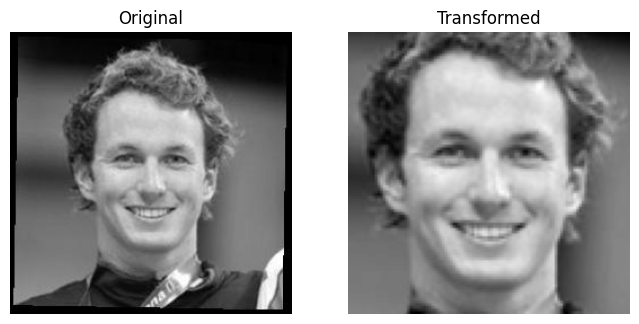

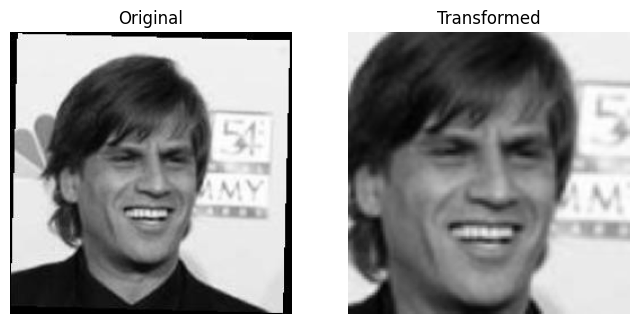

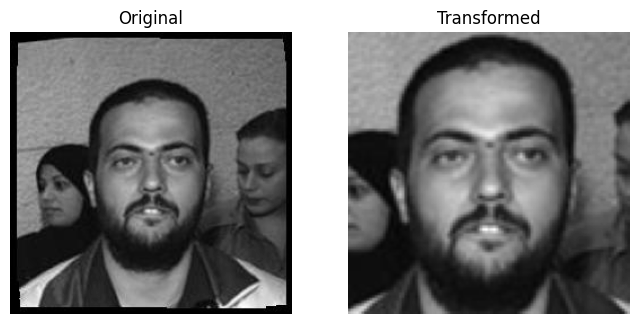

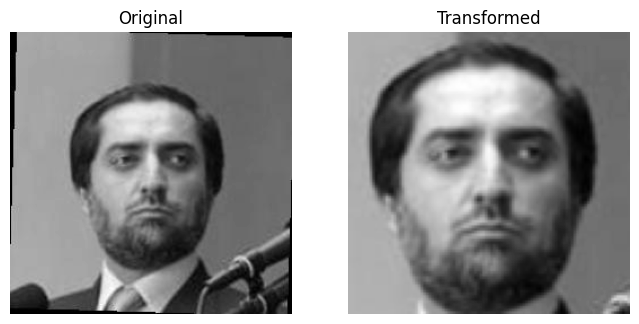

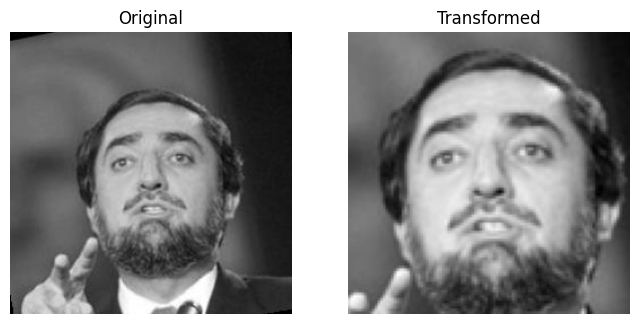

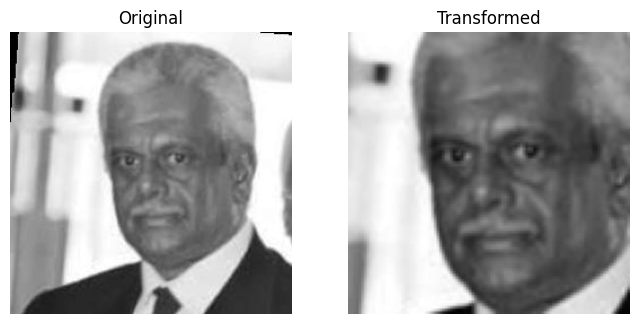

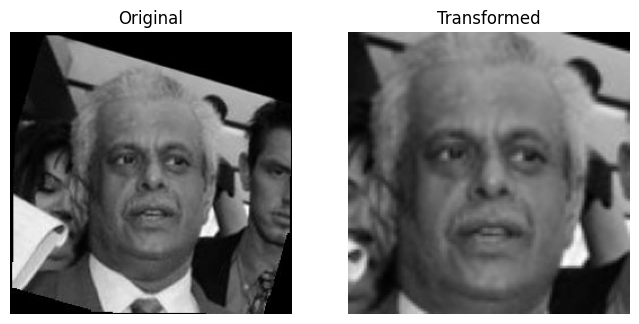

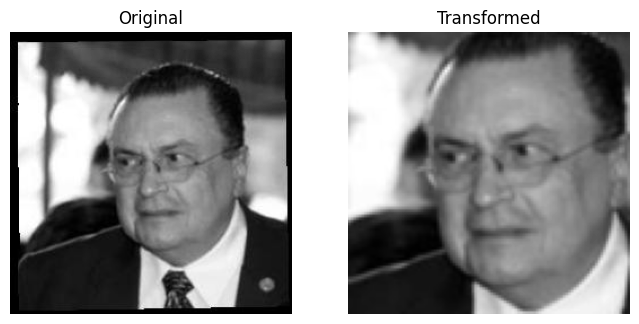

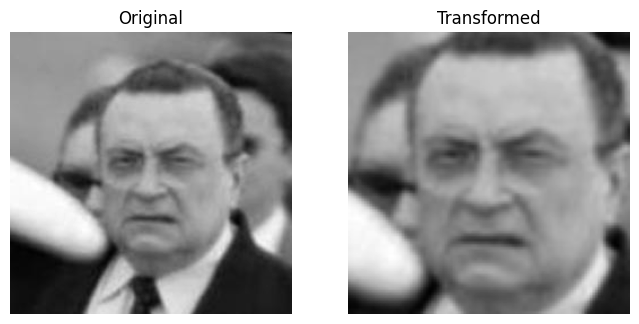

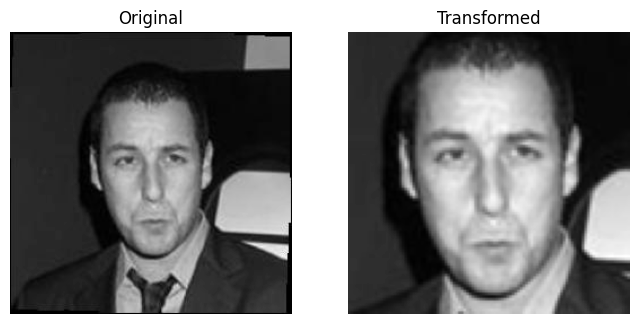

----------------------------------------------------------------------------------------------------
Augumantation Images


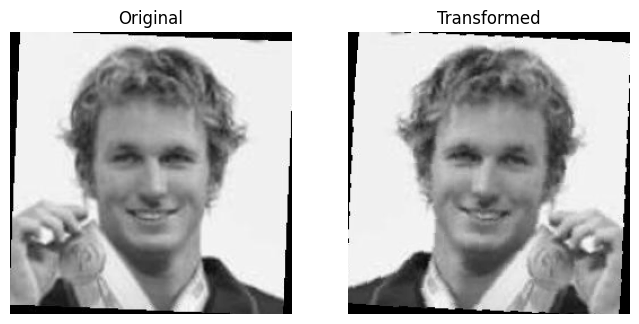

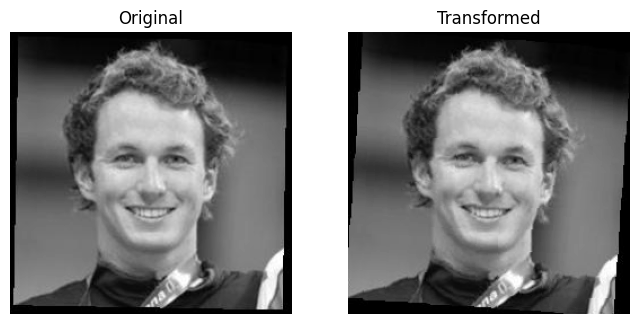

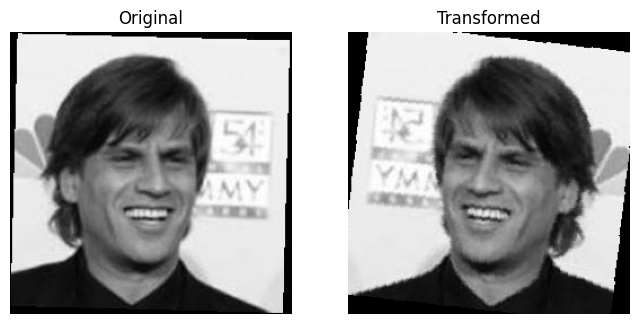

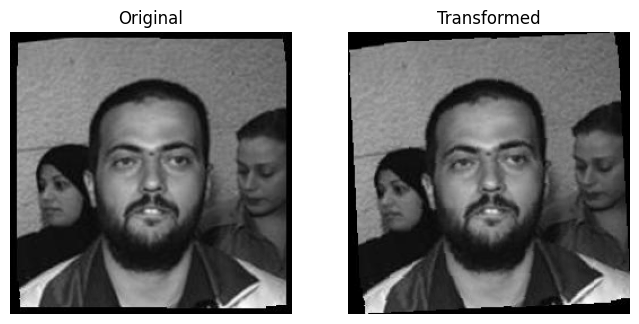

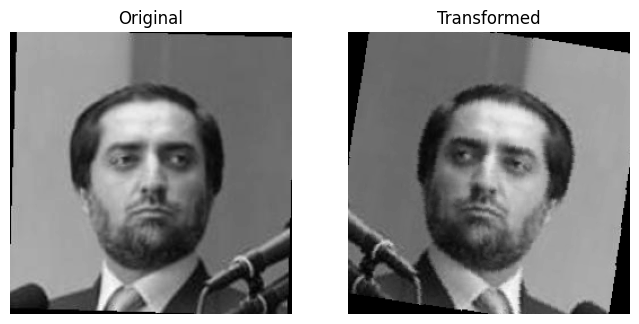

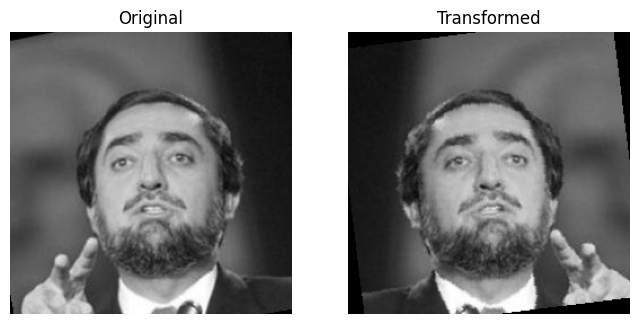

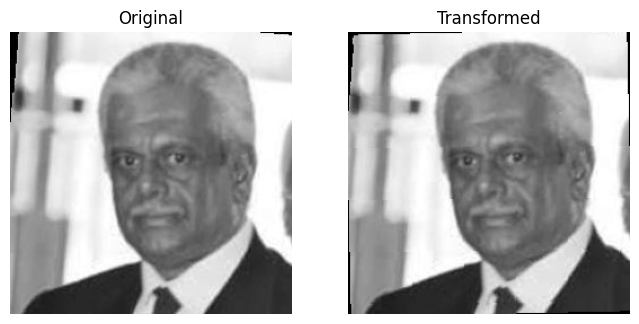

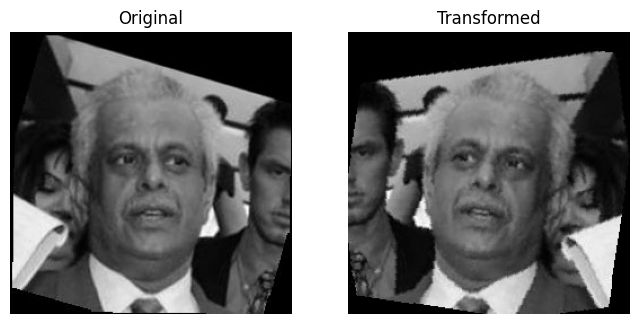

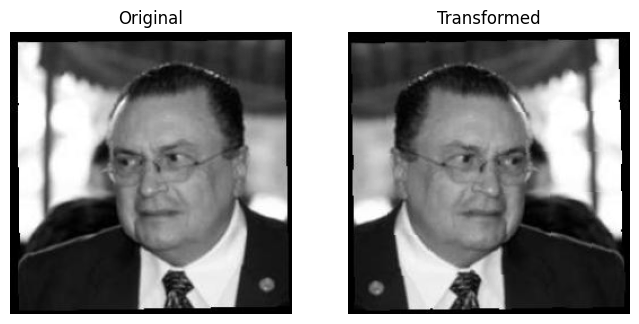

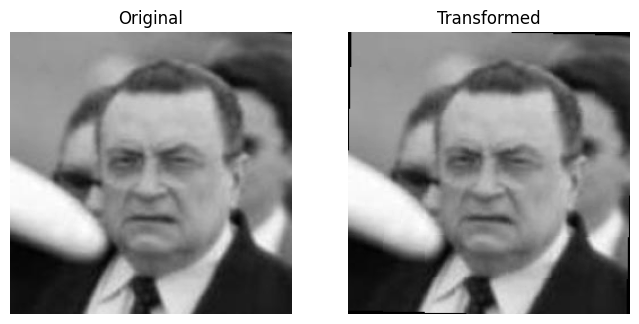

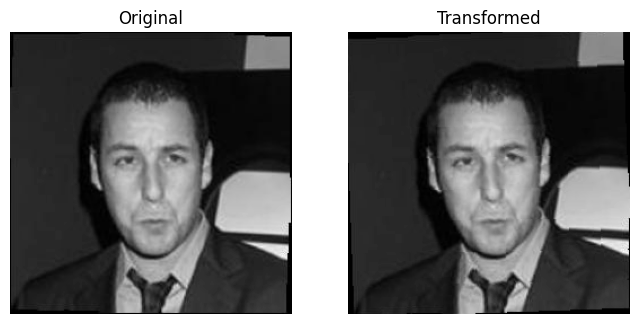

In [385]:
import matplotlib.pyplot as plt

# Define a custom transform to crop border pixels and resize
class CropResizeTransform:
    def __init__(self, border_pixels, new_size):
        self.border_pixels = border_pixels
        self.new_size = new_size
    def __call__(self, image):
        width, height = image.size
        left, top, right, bottom = self.border_pixels, self.border_pixels, width - self.border_pixels, height - self.border_pixels
        cropped_image = image.crop((left, top, right, bottom))
        resized_image = cropped_image.resize(self.new_size)
        return resized_image

border_pixels = 40  # Number of pixels to crop from each side
new_size = (105, 105)  # New size after resizing
transform = transforms.Compose([CropResizeTransform(border_pixels, new_size), transforms.Grayscale(num_output_channels=1)])

# Cropped 
print("Cropped Images")

for i, m in enumerate(train):
    image_path = f"./lfw2/lfw2/{m[0]}/{m[0]}_000{m[1]}.jpg"
    try:
        im = Image.open(image_path)
    except:
        continue
    im_transformed = transform(im)

    # Display original and transformed images side by side
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(im, cmap='gray')
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(im_transformed, cmap='gray')
    plt.title("Transformed")
    plt.axis('off')

    plt.show()

    if i == 10:
        break
        
# ----------------------------------------------------------------------------------------------------------------
print("-" * 100)

# Augumantation 


transform_aug = transforms.Compose([
            transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
            transforms.RandomRotation(degrees=10)])  # Randomly rotate the image by up to 10 degrees

print("Augumantation Images")


for i, m in enumerate(train):
    image_path = f"./lfw2/lfw2/{m[0]}/{m[0]}_000{m[1]}.jpg"
    try:
        im = Image.open(image_path)
    except:
        continue
    im_transformed = transform_aug(im)

    # Display original and transformed images side by side
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(im, cmap='gray')
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(im_transformed, cmap='gray')
    plt.title("Transformed")
    plt.axis('off')

    plt.show()

    if i == 10:
        break

## ***1.2 +  2. Calculate the number of samples with the same and different persons in each dataset, Split to train and validation sets***

In [386]:
# Calculate the number of samples with the same and different persons in each dataset
def count_samples(data_rows):
    same_person = sum([1 for row in data_rows if len(row) == 3])
    different_person = len(data_rows) - same_person
    return same_person, different_person

import numpy as np
from sklearn.model_selection import train_test_split

# split to train ans test
train, val = train_test_split(train, test_size=0.15, random_state=42)

# Define the dataset splits
train_same, train_not = count_samples(train)
val_same, val_not = count_samples(val)
test_same, test_not = count_samples(test)

print("Train set:")
print("Number of samples of the same person:", train_same)
print("Number of samples of different persons:", train_not, "\n")

print("Validation set:")
print("Number of samples of the same person:", val_same)
print("Number of samples of different persons:", val_not, "\n")

print("Test set:")
print("Number of samples of the same person:", test_same)
print("Number of samples of different persons:", test_not)


Train set:
Number of samples of the same person: 926
Number of samples of different persons: 944 

Validation set:
Number of samples of the same person: 174
Number of samples of different persons: 156 

Test set:
Number of samples of the same person: 500
Number of samples of different persons: 500


# ***3. Implement a Siamese network architecture***
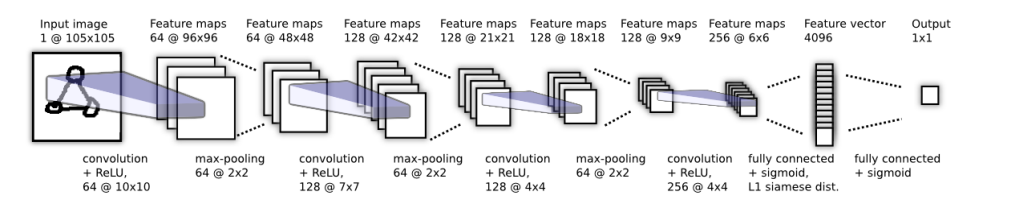

## ***3.1 Define Model architecture***

In [387]:
import torch.nn as nn
import torch.nn.functional as F

class SiameseCNN(nn.Module):
    def __init__(self, use_batch_norm=False, use_dropout=False, dropout_rate=0.0):
        super(SiameseCNN, self).__init__()

        # initializing layers separately
        # convolutional layers
        self.conv1 = nn.Conv2d(1, 64, kernel_size=10, stride=1, padding=0)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=7, stride=1, padding=0)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=4, stride=1, padding=0)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=4, stride=1, padding=0)

        # batch normalization layers
        self.bn1 = nn.BatchNorm2d(64) if use_batch_norm else nn.Identity()
        self.bn2 = nn.BatchNorm2d(128) if use_batch_norm else nn.Identity()
        self.bn3 = nn.BatchNorm2d(128) if use_batch_norm else nn.Identity()
        self.bn4 = nn.BatchNorm2d(256) if use_batch_norm else nn.Identity()

        # dropout layers
        self.dropout1 = nn.Dropout2d(dropout_rate) if use_dropout else nn.Identity()
        self.dropout2 = nn.Dropout2d(dropout_rate) if use_dropout else nn.Identity()
        self.dropout3 = nn.Dropout2d(dropout_rate) if use_dropout else nn.Identity()
        self.dropout4 = nn.Dropout2d(dropout_rate) if use_dropout else nn.Identity()

        # fully connected and dropout layers
        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.fc_dropout = nn.Dropout(dropout_rate) if use_dropout else nn.Identity()
        self.fc2 = nn.Linear(4096, 1)

        # max-pooling layer
        self.pool = nn.MaxPool2d(2)

    def forward_once(self, x):
        # applying layers separately
        # convolutional, batch normalization, ReLU, dropout, and max-pooling layers
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout1(x)


        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout3(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.dropout4(x)

        # Flatten the output
        x = x.view(x.size(0), -1)

        # Fully connected layers with optional dropout and sigmoid activation
        x = self.fc1(x)
        x = self.fc_dropout(x)
        x = torch.sigmoid(x)

        return x

    def forward(self, input1, input2):
        # generate the embeddings for the two inputs
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        # calculate the L1 distance between the embeddings
        l1_distance = torch.abs(output1 - output2)

        # pass the L1 distance through the final fully connected layer
        similarity_score = torch.sigmoid(self.fc2(l1_distance))

        return similarity_score

# instantiate the network with separate options for batch normalization and dropout
model = SiameseCNN()

# display the network architecture
model

SiameseCNN(
  (conv1): Conv2d(1, 64, kernel_size=(10, 10), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
  (bn1): Identity()
  (bn2): Identity()
  (bn3): Identity()
  (bn4): Identity()
  (dropout1): Identity()
  (dropout2): Identity()
  (dropout3): Identity()
  (dropout4): Identity()
  (fc1): Linear(in_features=9216, out_features=4096, bias=True)
  (fc_dropout): Identity()
  (fc2): Linear(in_features=4096, out_features=1, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [388]:
# cheak that cuda is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## ***4. Train the Model Process***

## ***4.1 Init Weights***

In [389]:
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.normal_(m.weight, mean=0.0, std=1e-2) #init conv weight
        nn.init.normal_(m.bias, mean=0.5, std=1e-2)   #init conv bias
        
    elif isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0.0, std=2e-1) #init Linear weight
        nn.init.normal_(m.bias, mean=0.5, std=1e-2)   #init Linear bias

## ***4.2 Define Accuracy func***

In [390]:
def calculate_accuracy(outputs, labels):
    preds = outputs > 0.5
    correct = (preds == labels).float()  # Convert boolean to float
    accuracy = correct.sum() / len(correct)
    return accuracy


## ***4.3 + 4.4  Define Grid Search and Train the Model and Choose Best HyperParameters***

In [ ]:
import os
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import time
import pandas as pd
import itertools
import glob

lr_rates = [0.001,0.00005,0.00001,0.000005]
weight_decays = [0,0.05,0.1]
batch_sizes = [16, 32]
use_batch_norms = [True, False]
use_dropouts = [True, False]

# Create a grid of hyperparameters combinations
param_grid = list(itertools.product(lr_rates, weight_decays, batch_sizes, use_batch_norms, use_dropouts))

# Set random seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Create an experiment directory
experiment_dir = 'experiment'
os.makedirs(experiment_dir, exist_ok=True)

# Assuming ImageLoader and SiameseCNN are defined elsewhere
train_dataset = ImageLoader(train)
val_dataset = ImageLoader(val)
test_dataset = ImageLoader(test)

# Loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=6)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=6)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=6)

# Set number of epochs and initiate stopping criteria
num_epochs = 200
early_stop_epochs = 10

# Results DataFrame
results_df = pd.DataFrame(columns=['Epoch', 'Train Loss', 'Train Acc', 'Val Loss', 'Val Acc', 'Convergence Time', 'Test Acc'])

# For each combination
for param_combination in param_grid:
    lr, weight_decay, batch_size, use_batch_norm, use_dropout = param_combination
    
    experiment_subdir = f"{num_epochs}_{lr}_{weight_decay}_{batch_size}_{use_batch_norm}_{use_dropout}"
    experiment_dir = os.path.join('experiments', experiment_subdir)
    os.makedirs(experiment_dir, exist_ok=True)

    model = SiameseCNN(use_batch_norm=use_batch_norm, use_dropout=use_dropout, dropout_rate=0.5)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.BCELoss()
    scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.99)

    best_val_loss = float('inf')
    best_model_state_dict = None
    best_epoch = -1
    train_losses = []
    val_losses = []
    train_accuary_lst = []
    val_accuary_lst = []
    

    for epoch in range(num_epochs):
        start_time = time.time()

        model.train()
        train_loss = 0.0
        train_acc = 0.0

        train_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Training]")
        for images1, images2, labels in train_bar:
            images1, images2, labels = images1.to(device), images2.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images1, images2)
            loss = criterion(outputs, labels.unsqueeze(1))
            acc = calculate_accuracy(outputs, labels.unsqueeze(1))

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_acc += acc.item()

        train_loss /= len(train_loader)
        train_acc /= len(train_loader)

        model.eval()
        val_loss = 0.0
        val_acc = 0.0
        with torch.no_grad():
            for images1, images2, labels in val_loader:
                images1, images2, labels = images1.to(device), images2.to(device), labels.to(device)

                outputs = model(images1, images2)
                loss = criterion(outputs, labels.unsqueeze(1))
                acc = calculate_accuracy(outputs, labels.unsqueeze(1))

                val_loss += loss.item()
                val_acc += acc.item()

        val_loss /= len(val_loader)
        val_acc /= len(val_loader)

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        train_losses.append(train_loss)
        train_accuary_lst.append(train_acc)
        val_losses.append(val_loss)
        val_accuary_lst.append(val_acc)
        

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch

        best_model_state_dict = model.state_dict()

        model_name = os.path.join(experiment_dir, f"siamese_lr{lr}_decay{weight_decay}_batch{batch_size}_bn{use_batch_norm}_dropout{use_dropout}_epoch{epoch}.pt")
        torch.save(best_model_state_dict, model_name)

        test_acc = 0.0
        model.eval()
        with torch.no_grad():
            for images1, images2, labels in test_loader:
                images1, images2, labels = images1.to(device), images2.to(device), labels.to(device)
                outputs = model(images1, images2)
                acc = calculate_accuracy(outputs, labels.unsqueeze(1))
                test_acc += acc.item()

        test_acc /= len(test_loader)

        convergence_time = time.time() - start_time
        results_df = pd.concat([results_df, pd.DataFrame({'Epoch': [epoch + 1], 'Train Loss': [train_loss], 'Train Acc': [train_acc], 'Val Loss': [val_loss], 'Val Acc': [val_acc], 'Convergence Time': [convergence_time], 'Test Acc': [test_acc]})], ignore_index=True)

        if epoch - best_epoch >= early_stop_epochs:
            print(f"Stopping early at epoch {epoch + 1} due to no improvement in validation loss for {early_stop_epochs} consecutive epochs.")
            break

        scheduler.step()

    # Save the results DataFrame to a CSV file
    results_csv = os.path.join(experiment_dir, 'results.csv')

    # Check if the CSV file exists
    if os.path.exists(results_csv):
        # If it exists, delete it
        os.remove(results_csv)
    
    # Save the new CSV file
    results_df.to_csv(results_csv, index=False)
    print('Total Convergence Time', results_df['Convergence Time'].sum())
    
    # Plot training and validation losses
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Losses')
    plt.savefig(os.path.join(experiment_dir, 'loss_plot.png'))
    plt.show()
    
    # Plot training and validation Accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(train_accuary_lst, label='Train Accuracy')
    plt.plot(val_accuary_lst, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuray')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.savefig(os.path.join(experiment_dir, 'accuracy_plot.png'))
    plt.show()
    
    
    # Ensure only the best model remains in the experiment directory
    pt_files = glob.glob(os.path.join(experiment_dir, '*.pt'))
    # Ensure there are .pt files in the directory
    if not pt_files:
        print("No .pt files found in the directory.")
    else:
        for file in pt_files:
            if 'epoch' + str(best_epoch) not in str(file):
                try:
                    os.remove(file)
                except FileNotFoundError:
                    continue

## ***5 Evaluate Model Peroformance***

## ***5.1 Load Model Weights***

In [ ]:
# load model weights 
model_path = "PATH TO SAVED MODEL"
model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))

## ***5.2 Calculate accuracy and display confusion Matrix***

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

torch.manual_seed(seed)

all_preds = []
all_labels = []
all_probs = []
batch_size = 16

test_dataset = ImageLoader(test, False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=6)

# Set model to evaluation mode
model.eval()

with torch.no_grad():
    for images1, images2, labels in test_loader:
        outputs = model(images1.to(device), images2.to(device))
        predicted = outputs > 0.5
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(outputs.cpu().numpy())

# Convert lists to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# Calculate metrics
cm = confusion_matrix(all_labels, all_preds)
accuracy = np.trace(cm) / np.sum(cm).astype('float')

print(f'Model Accuracy: {accuracy:.3f}')

# Plot the heatmap
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix on Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


## ***5.3 Analyze Results***

In [ ]:
# Find indices of TP, TN, FP, and FN
tp_index = None
tn_index = None
fp_index = None
fn_index = None

for i in range(len(all_preds)):
    if all_labels[i] == 1.0 and all_probs[i] > 0.5:
        tp_index = i
    elif all_labels[i] == 0.0 and all_probs[i] < 0.5 :
        tn_index = i
    elif all_labels[i] == 1.0 and all_probs[i] < 0.5:
        fn_index = i
    elif all_labels[i] == 0.0 and  all_probs[i] > 0.5:
        fp_index = i

In [ ]:
def plot_images(sample, proba):
    if len(sample) == 3:
        name, p_num1, p_num2 = sample
        image_path = f"./lfw2/lfw2/{name}/{name}_000{p_num1}.jpg"
        image_path2 = f"./lfw2/lfw2/{name}/{name}_000{p_num2}.jpg"
    else: # len is 4
        name, p_num1, name2,  p_num2 = sample
        image_path = f"./lfw2/lfw2/{name}/{name}_000{p_num1}.jpg"
        image_path2 = f"./lfw2/lfw2/{name2}/{name2}_000{p_num2}.jpg"

    im = Image.open(image_path)
    im2 = Image.open(image_path2)
    print("The probability is:",proba[0]) 
    print("\n")

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(im, cmap='gray')
    plt.title("Image 1")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(im2, cmap='gray')
    plt.title("Image 2")
    plt.axis('off')
    
    plt.subplots_adjust(wspace=0.01)
    plt.show()